In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model, to_categorical

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist



from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization import plot_histogram
from qiskit.extensions.unitary import unitary
from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile, assemble
S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]

import numpy as np

In [19]:
def quanvolution(param):
    q = QuantumRegister(4, name = 'q_r')
    a = QuantumRegister(1, name = 'a_r')
    c = ClassicalRegister(1, name = 'c_r')
    qc = QuantumCircuit(q, a, c, name = 'q_circ')

    qc.h(q)

    qc.u3(param[0, 0], param[0, 1], param[0, 2], q[0])
    qc.u3(param[1, 0], param[1, 1], param[1, 2], q[0])
    qc.u3(param[2, 0], param[2, 1], param[2, 2], q[0])
    qc.u3(param[3, 0], param[3, 1], param[3, 2], q[0])

    qc.mct(q, a, None, mode = 'noancilla')

    qc.measure(a[0], c)

    shots = 8192

    transpiled_circuit = transpile(qc, M_simulator, optimization_level = 1)
    job = M_simulator.run(assemble(transpiled_circuit, shots = shots))
    results = job.result()

    readout = results.get_counts()

    #print(readout.get('1', 0) / readout.get('0', shots))
    
    #qc.draw()
    
    return [readout.get('0', 0) / readout.get('1', shots)] * param.shape[-1]

In [5]:
quanvolution(np.random.normal(size = (4, 3)))

[79.31372549019608, 79.31372549019608, 79.31372549019608]

In [6]:
class Linear(layers.Layer):
    def __init__(self, units):
        super(Linear, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name = "w",
            shape = (input_shape[-1], self.units),
            initializer = "random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name = "b",
            shape = (self.units,), initializer="random_normal", trainable=True,
        )
        
        self.ww = tf.Variable(tf.random.normal((input_shape[-1], self.units)), name='ww')
        self.bb = tf.Variable(tf.zeros(self.units, dtype=tf.float32), name='bb')
        
    def get_config(self):
        config = super(Linear, self). get_config()
        return config

    def call(self, inputs):
        # Exotic calculations
        if tf.executing_eagerly():
            final_output = []
            for i in range(inputs.shape[0]):
                # Dummy operation
                pred = quanvolution(np.random.normal(size = (4, inputs.shape[-1])))
                final_output.append(list(pred))
                
            # Trying gradients
            with tf.GradientTape(persistent = True) as tape:
                y = tf.expand_dims(tf.convert_to_tensor(pred, dtype = "float32"), 0) @ self.ww + self.bb
                loss = tf.reduce_mean(y**2)
            [dl_dw, dl_db] = tape.gradient(loss, [self.w, self.b])
            #self.w.assign_add(self.w * 0.05)
            tf.print(self.w, self.b)
            return  tf.matmul(tf.convert_to_tensor(final_output, dtype = tf.float32), self.ww) + self.bb
            #return  tf.matmul(tf.expand_dims(tf.convert_to_tensor(final_output, dtype = tf.float32), 0), tf.ones_like(self.ww))
            
            #return tf.convert_to_tensor(final_output, dtype = "float32")
        return tf.matmul(inputs, self.w) + self.b
    
class MyReLu(layers.Layer):
    def __init__(self):
        super(MyReLu, self).__init__()
    def call(self, x):
        return tf.math.maximum(x, 0)

In [7]:
x = tf.ones((1, 4))
linear_layer = Linear(12)
y = linear_layer(x)
print(y)

[[-0.0155270472 0.00519902492 -0.0744091 ... 0.00174781203 -0.0180194303 -0.0596778281]
 [-0.0682185367 0.0667566881 0.0380128846 ... 0.106374316 0.0884074345 0.00763507187]
 [0.0831688 0.0488449857 0.0659694597 ... 0.143470377 0.0090736812 0.0143952547]
 [0.0261708833 0.0221983325 -0.0837919042 ... 0.0237478018 0.0158366635 0.0968842432]] [-0.00970076676 0.0655956119 0.0824452266 ... -0.0370389782 0.064668 -0.0267453473]
tf.Tensor(
[[ 2.47103672e+01 -1.64199028e+01  2.24806747e+01 -1.48315735e+01
  -1.77705193e+01 -3.08490086e+01 -4.01897125e+01  1.47207127e+01
  -2.87533932e+01 -1.52840834e+01 -1.70812607e-02  1.45157661e+01]], shape=(1, 12), dtype=float32)


In [8]:
iris = load_iris()
data = iris.data
targets = iris.target

targets = to_categorical(targets)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state = 42)

In [10]:
# Loading MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
#original_inputs = Input(shape = (4,), name = "input")
model = Sequential()

model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 32, activation = 'relu', name = 'Dense_1'))
model.add(Dropout(0.2))

model.add(Dense(units = 16, activation = 'relu', name = 'Dense_2'))
model.add(Dropout(0.2))

model.add(Dense(units = 16,  activation = 'relu', name = 'Dense_3'))
model.add(Dropout(0.2))

model.add(Dense(units = 10, activation = 'softmax'))

#model = Model(inputs = original_inputs, outputs = outputs, name = 'custom_model')

In [12]:
model = Sequential()

model.add(Dense(units = 64))
model.add(MyReLu())
model.add(Dropout(0.2))

model.add(Dense(units = 32))
model.add(MyReLu())
model.add(Dropout(0.2))

model.add(Dense(units = 6))
model.add(MyReLu())
model.add(Dropout(0.2))

model.add(Linear(units = 4))
model.add(MyReLu())
model.add(Dropout(0.2))

model.add(Dense(units = 10, activation = 'softmax'))

In [17]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', run_eagerly = True, metrics = ['accuracy'])

In [18]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 2, batch_size = 32, verbose = 1)

Epoch 1/2


StagingError: in user code:

    <ipython-input-15-7f7ee9dce0d1>:10 quanvolution  *
        qc.u3(param[0, 0], param[0, 1], param[0, 2], q[0])
    C:\Users\jeff_\Anaconda3\lib\site-packages\qiskit\util.py:1943 wrapper  *
        return func(*args, **kwargs)
    C:\Users\jeff_\Anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:2183 u3  *
        return self.append(U3Gate(theta, phi, lam), [qubit], [])
    C:\Users\jeff_\Anaconda3\lib\site-packages\qiskit\circuit\library\standard_gates\u3.py:65 __init__  **
        super().__init__('u3', 1, [theta, phi, lam], label=label)
    C:\Users\jeff_\Anaconda3\lib\site-packages\qiskit\circuit\gate.py:40 __init__
        super().__init__(name, num_qubits, 0, params)
    C:\Users\jeff_\Anaconda3\lib\site-packages\qiskit\circuit\instruction.py:84 __init__
        self.params = params
    C:\Users\jeff_\Anaconda3\lib\site-packages\qiskit\circuit\instruction.py:164 params
        "{1}".format(type(single_param), self.name))

    CircuitError: "invalid param type <class 'tensorflow.python.framework.ops.Tensor'> in instruction u3"


In [88]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

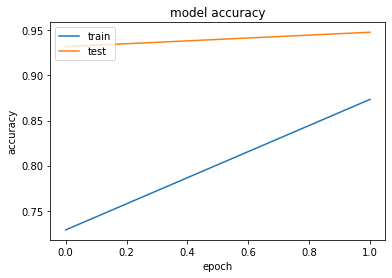

In [89]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

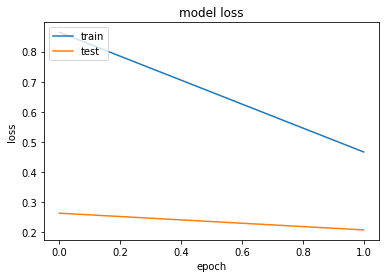

In [90]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()